# Continuous Pendulum with function appoximation and control

This Notebook is intended to solve the Continuous Pendulum problem using Policy gradient methods (Deep actor-critic).

The description of the problem is given below:

"The inverted pendulum swingup problem is a classic problem in the control literature. In this version of the problem, the pendulum starts in a random position, and the goal is to swing it up so it stays upright.." 

<img src="./assets/pendulum.png" width="380" />

Image and Text taken from Taken from [Official documentaiton Pendulum](https://gym.openai.com/envs/Pendulum-v0/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import gym
from gym.wrappers import Monitor
from utils import *

import torch
from torch import nn
import torch.nn.functional as F
from torch import optim

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Markov Decision Process

As a quick recap, the diagram below explains the workflow of a Markov Decision Process (MDP)

<img src="./assets/MDP.png" width="380" />

Image taken from [Section 3.1 Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=70)

## Environment and Agent specifications

The states, actions, reward and termination are given as follows for the lunar lander problem.

**Observation**: 

     Type:  Box(2)
     Num 	Observation 	 Min 	Max
     0 	  cos(theta)      -1.0 	1.0
     1 	  sin(theta) 	 -1.0 	1.0
     2       theta dot 	  -8.0 	8.0
         
**Actions**:

     Type: Box(1)
     Num 	Action 	        Min 	Max
     0 	  Joint effort      -2.0 	2.0

        
**Reward**:

     -(theta^2 + 0.1*theta_dt^2 + 0.001*action^2)

        
**Starting State**:

     Random angle from -pi to pi, and random velocity between -1 and 1
        
**Episode Termination**:

     Continuous problem
     
For further information see [Github source code](https://github.com/openai/gym/blob/master/gym/envs/classic_control/pendulum.py)

The next cell aims to show how to iterate with the action and observation space of the agent and extract relevant information from it 

In [2]:
env = gym.make("Pendulum-v0")
observation = env.reset() 

# Object's type in the action Space
print("The Action Space is an object of type: {0}\n".format(env.action_space))
# Shape of the action Space
print("The shape of the action space is: {0}\n".format(env.action_space.shape))
# The high and low values in the action space
print("The High values in the action space are {0}, the low values are {1}\n".format(
    env.action_space.high, env.action_space.low))
# Object's type in the Observation Space
print("The Environment Space is an object of type: {0}\n".format(env.observation_space))
# Shape of the observation space
print("The Shape of the dimension Space are: {0}\n".format(env.observation_space.shape))
# The high and low values in the observation space
print("The High values in the observation space are {0}, the low values are {1}\n".format(
    env.observation_space.high, env.observation_space.low))
# Example of observation
print("The Observations at a given timestep are {0}\n".format(env.observation_space.sample()))

# https://medium.com/deeplearningmadeeasy/advantage-actor-critic-continuous-case-implementation-f55ce5da6b4c
# https://www.coursera.org/learn/prediction-control-function-approximation/home/welcome
# [Section 3.1 Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=357)

The Action Space is an object of type: Box(1,)

The shape of the action space is: (1,)

The High values in the action space are [2.], the low values are [-2.]

The Environment Space is an object of type: Box(3,)

The Shape of the dimension Space are: (3,)

The High values in the observation space are [1. 1. 8.], the low values are [-1. -1. -8.]

The Observations at a given timestep are [-0.48172188 -0.47738546 -1.0262377 ]



## Critic Neural Network

For this problem, the critic is a Neural Network with a single output. The input dimension is equal to the number of states in the problem. Recall that.

$$ v_\pi(s) \approx \hat{v}(s, w) = NN(s, w) $$

For further information about Neural Networks for function approximation see [Section 9.7 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=246)

In [3]:
# Critic Neural Network
class Critic(nn.Module):
    # Work Required: Yes. Fill in the layer_sizes member variable (~1 Line).
    def __init__(self, critic_config):
        super().__init__()
        
        # Number of states
        self.state_dim = critic_config.get("state_dim")
        # Hidden units
        self.num_hidden_units = critic_config.get("num_hidden_units")
        
        # Number of nodes in the first hidden layer
        self.hidden1_units = int(self.num_hidden_units / 4)
        # Number of nodes in the second hidden layer
        self.hidden2_units = int(self.num_hidden_units / 2)
        
        # Initialzie first hidden layer 
        self.hidden_1 = nn.Linear(self.state_dim, self.hidden1_units)
        # Initialzie second hidden layer 
        self.hidden_2 = nn.Linear(self.hidden1_units, self.hidden2_units)
        # Initialzie Third hidden layer 
        self.hidden_3 = nn.Linear(self.hidden2_units, self.num_hidden_units)
        # Initialize output layer
        self.output = nn.Linear(self.num_hidden_units, 1)
                        
    
    def forward(self, s):
        """
        This is a feed-forward pass in the network
        Args:
            s (Numpy array): The state, a 2D array of shape (state_dim)
        Returns:
            The value estimates (Torch array) calculated using the network's weights.
            A 2D array of shape (num_actions)
        """
        # Transform observations into a pytorch tensor
        s = torch.Tensor(s)
        
        v = F.relu(self.hidden_1(s))
        v = F.relu(self.hidden_2(v))
        v = F.relu(self.hidden_3(v))
        v = self.output(v)

        return v

## Actor Neural Network

As this is a contininuous problem, it is possible to use a Normal distribution to sample actions. For this task, a neural network is used to compute $\mu$ and $\sigma$ which are the mean and standard deviation of a Normal Distribution.

$$ \pi(a | s, \theta) \doteq \frac{1}{\sigma(s, \theta) \sqrt{2\pi}}e^-{\frac{(a-\mu(s,\theta))^2}{2\sigma(s,\theta)^2}} $$

As $\mu$ and $\sigma$ are computed by the network, they are automatically adjusted depending on the current state of the problem. The input of the neural netork are the states of the problem, the output is composed of two nodes, ($\mu$ and $\sigma$) for a unique action in this problem.

For further explanation see [Section 13.7 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=357)

In [4]:
# The Actor neural network
class Actor(nn.Module):
    def __init__(self,  actor_config):
        super().__init__()
                
        # Number of states
        self.state_dim = actor_config.get("state_dim")
        # Hidden units
        self.num_hidden_units = actor_config.get("num_hidden_units")
        # Actions or output units
        self.num_actions = actor_config.get("num_actions")
        
        # Number of nodes in the first hidden layer
        self.hidden1_units = int(self.num_hidden_units / 4)
        # Number of nodes in the second hidden layer
        self.hidden2_units = int(self.num_hidden_units / 2)
        
        # Initialzie first hidden layer 
        self.hidden_1 = nn.Linear(self.state_dim, self.hidden1_units)
        # Initialzie second hidden layer 
        self.hidden_2 = nn.Linear(self.hidden1_units, self.hidden2_units)
        # Initialzie Third hidden layer 
        self.hidden_3 = nn.Linear(self.hidden2_units, self.num_hidden_units)
        # Initialize output layer (muliply output by 2 to obtain mu and sigma)
        self.output = nn.Linear(self.num_hidden_units, self.num_actions * 2)
        
        # Log of standard deviation
        # logstdv_param = nn.Parameter(torch.full((self.num_actions,), 0.1))
        # Register parameter in the network
        # self.register_parameter("logstdv", logstdv_param)
                
    def compute_mean(self, s):
        """
        This is a feed-forward pass in the network
        Args:
            s (Numpy array): The state, a 2D array of shape (state_dim)
        Returns:
            Mean and stdv (Torch array) calculated using the network's weights.
            A 2D array of shape (num_actions * 2)
        """
        # Transform observations into a pytorch tensor
        s = torch.Tensor(s)
        
        pi = F.relu(self.hidden_1(s))
        pi = F.relu(self.hidden_2(pi))
        pi = F.relu(self.hidden_3(pi))
        pi = self.output(pi)
        
        return pi
                
    
    def forward(self, s):
        
        # Compute the mean and log stedv with the model
        mean, logstdv = self.compute_mean(s)
        # Exp the log stdv (To avoid negative values)
        stdv = logstdv.exp()
        
        # Clamp the stdv between 1e-3 and 50
        #stdv = torch.clamp(logstdv.exp(), 1e-3, 50)
        
        # Sample an action from the normal distribution
        return torch.distributions.Normal(mean, stdv)


## Computing TD target and TD estimate

The TD target and TD estimate's computation will be done in the next lines. The main idea here is to obtain both TD values from the Critic's network.

The TD error is composed of two values, the TD estimate and TD Target.

$$ \delta = [R_{t+1} + \gamma \hat{v}(S_{t+1}, w) - \hat{v}(s_t,w)] = \text{TD error} $$
 
Recall that the TD Target is given by.

$$ R_{t+1} + \gamma \hat{v}(S_{t+1}, w) $$

Similarly, the TD estimate is.

$$ \hat{v}(s_t,w) $$


For further explanation about TD methods see [Section 6.1 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=141)


In [5]:
# Method to compute the TD Target and TD estimate
def get_td(states, next_states, rewards, terminals, critic, discount):
    """
    Args:
        states (Numpy array): States with shape (state_dim).
        next_states (Numpy array): Next states with shape (state_dim).
        rewards (float): Current reward.
        terminals (float): Terminal state.
        critic (Critic): The critic neural network used to compute value estimates
        discount (float): The discount factor (gamma).
    Returns:
        target_vec (Tensor value): The TD Target.
        estimate_vec (Tensor value): The TD estimate.
    """
    # Compute value estimates for the next states
    v_next_vals = critic.forward(next_states)
    # Compute value estimates for the current states (TD estimate)
    v_curr_vals = critic.forward(states)
    
    # Compute the TD Target
    target_vec = torch.tensor(rewards) + (discount * v_next_vals * (1 - torch.tensor(terminals)))
 
    return target_vec, v_curr_vals

## Clipping the gradients

To guarantee stability in the training process, it is necessary to clip the gradients of the networks.

In [6]:
def clip_grad_norm_(module, max_grad_norm):
    nn.utils.clip_grad_norm_([p for g in module.param_groups for p in g["params"]], max_grad_norm)

## Implementing Actor-Critic Agent

The final step is to implement the Agent. The training process is cyclical as this is a continuous task and the sequence goes as follows.

$\delta_t = R_{t+1}  + \gamma \hat{v}(S_{t+1}, \mathbf{w}) - \hat{v}(S_{t}, \mathbf{w}) \hspace{6em}  (1)$

**Critic weight update rule**: $\mathbf{w} \leftarrow \mathbf{w} + \alpha^{\mathbf{w}}\delta\nabla \hat{v}(s,\mathbf{w}) \hspace{2.5em} (2)$

**Actor weight update rule**: $\mathbf{\theta} \leftarrow \mathbf{\theta} + \alpha^{\mathbf{\theta}}\delta\nabla ln \pi(A|S,\mathbf{\theta}) \hspace{1.4em} (3)$

For further details, see [Section 13.5 of Reinforment Learning an Introduction](http://www.incompleteideas.net/book/RLbook2018.pdf#page=353).

In [7]:
# Actor-Critic Agent
class ActorCritic():
    """
    Initialization of Actor-Critic Agent. All values are set to None so they can
    be initialized in the agent_init method.
    """
    def __init__(self):
        """Setup for the agent called when the experiment first starts."""
        self.actor_step_size = None
        self.critic_step_size = None
        self.avg_reward_step_size = None

        self.avg_reward = None
        self.critic = None
        self.actor = None

        self.actions = None

        self.last_action = None
        self.last_state = None

    def agent_init(self, agent_config = {}):
        """Setup for the agent called when the experiment first starts."""
        
        # Step size parameters
        self.actor_step_size = agent_config['optimizers_config']['actor_step_size']
        self.critic_step_size = agent_config['optimizers_config']['critic_step_size']
        self.discount = agent_config['optimizers_config']['gamma']
        
        # Set number of actions
        self.actions = agent_config['network_config']['num_actions']
        
        # Initialize actor and critic networks
        self.actor = Actor(agent_config['network_config']).to(device)
        self.critic = Critic(agent_config['network_config']).to(device)
        
        # Critic Loss
        self.critic_loss = nn.MSELoss()
        
        # Loss variables
        self.actor_loss_val = 0
        self.critic_loss_val = 0
        
        # Actor and Critic optimizer
        self.actor_opti = optim.Adam(self.actor.parameters(), lr = self.actor_step_size ) 
        self.critic_opti = optim.Adam(self.critic.parameters(), lr = self.critic_step_size )
        
        self.last_action = None
        self.last_state = None

    def select_action(self, state):
        """
        Selects an action using epsilon greedy
        Args:
            state (Numpy array): the state.
        Returns:
            chosen_action (float)
        """
        # Pass the states to create the normal distribution
        dist = self.actor.forward(state)
        # Sample an action from the current normal Distribution
        action = dist.sample().detach().data.numpy()
        # Clip action to a given range (Max and Min in action space)
        chosen_action = np.clip(action, env.action_space.low.min(), env.action_space.high.max())
        
        #self.log_probs = dists.log_prob(torch.tensor(action).detach())
        #m = nn.Tanh()
        #chosen_action = m(action) * env.action_space.high.max()

        return [chosen_action]
    
    def agent_start(self, state):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            state (Numpy array): the state observation from the
                environment's env.reset() function.
        Returns:
            The first action the agent takes.
        """
        # Select an action given the current state
        current_action = self.select_action(state)

        # Save action as last action
        self.last_action = current_action
        # Save tiles as previous tiles
        self.last_state = state
        
        return self.last_action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """
        # Compute TD values
        td_target, td_estimate = get_td(self.last_state, state, reward, 0, self.critic, self.discount)
        # TD error calculation
        delta = td_target - td_estimate
        
        # Critic
        # zero the gradients buffer
        self.critic_opti.zero_grad()
        # Compute the  Mean squared value error loss
        critic_loss = self.critic_loss(td_estimate.double().to(device), td_target.double().detach().to(device))
        #critic_loss = delta**2
        # Backprop the error
        critic_loss.backward()
        # Clip the gradients to 0.5
        clip_grad_norm_(self.critic_opti, 0.5)
        # Optimize critic's network
        self.critic_opti.step()
        
        # Actor 
        self.actor_opti.zero_grad()
        # Compute mu and sigma
        norm_dists = self.actor.forward(self.last_state)
        # Construct equivalent loss function
        logs_probs = norm_dists.log_prob(torch.tensor(self.last_action))
        #entropy = norm_dists.entropy() # - entropy * 0.0001
        # Multiply by minus one as this is gradient ascent
        actor_loss = -logs_probs * delta.detach() 
        # Backprop the error
        actor_loss.backward()
        # Clip the actor's gradients
        clip_grad_norm_(self.actor_opti, 0.5)
        # Optimize the actor's network
        self.actor_opti.step()
        
        self.actor_loss_val += actor_loss.detach().numpy()
        self.critic_loss_val += critic_loss.detach().numpy()
        
        # Compute new action
        current_action = self.select_action(state)

        self.last_state = state
        self.last_action = current_action

        return self.last_action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """

        # There is no action_value used here because this is the end
        # of the episode.
        
        # Create state full of zeroes
        state = np.zeros_like(self.last_state)
        
        # Compute TD values
        td_target, td_estimate = get_td(self.last_state, state, reward, 1, self.critic, self.discount)
        # TD error
        delta = td_target - td_estimate

        
        # Critic
        # zero the gradients buffer
        self.critic_opti.zero_grad()
        # Compute the  Mean squared value error loss
        critic_loss = self.critic_loss(td_estimate.double().to(device), td_target.double().detach().to(device))
        #critic_loss = delta**2
        # Backprop the error
        critic_loss.backward()
        # Clip the gradients to 0.5
        clip_grad_norm_(self.critic_opti, 0.5)
        # Optimize critic's network
        self.critic_opti.step()
        
        # Actor 
        self.actor_opti.zero_grad()
        # Compute mu and sigma
        norm_dists = self.actor.forward(self.last_state)
        # Construct equivalent loss function
        logs_probs = norm_dists.log_prob(torch.tensor(self.last_action))
        #entropy = norm_dists.entropy() # - entropy * 0.0001
        # Multiply by minus one as this is gradient ascent
        actor_loss = -logs_probs * delta.detach() 
        # Backprop the error
        actor_loss.backward()
        # Clip the actor's gradients
        clip_grad_norm_(self.actor_opti, 0.5)
        # Optimize the actor's network
        self.actor_opti.step()
        
        self.actor_loss_val += actor_loss.detach().numpy()
        self.critic_loss_val += critic_loss.detach().numpy()

## Running the experiment

The following lines solves the Pendulum problem and plot the average reward obtained over episodes and steps taken to solve the challenge at a specific episode (The experiment is over every x amount of steps).

In [8]:
# Test the Actor-Critic agent

num_runs = 1
num_episodes = 5

agent_info = {
             'network_config': {
                 'state_dim': env.observation_space.shape[0],
                 'num_hidden_units': 64,
                 'num_actions': env.action_space.shape[0]
             },
             'optimizers_config': {
                 'actor_step_size': 1e-7,  #5e-6, 1e-5 
                 'critic_step_size': 1e-4, 
                 'gamma': 0.99, 
             }}

# Variable to store the amount of steps taken to solve the challeng
all_steps = []
# Variable to save the rewards in an episode
all_rewards = []
# Save actor and critic losses
all_loss_c = []
all_loss_a = []

# Agent
agent = ActorCritic()

# Environment
env = gym.make('Pendulum-v0')
env.reset()
# Maximum number of possible iterations (default was 200)
env._max_episode_steps = 500

# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in range(num_runs):
    
    # Resets environment
    observation = env.reset()
    # Reset agent
    agent.agent_init(agent_info)
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
    # Steps, rewards and loss at each episode to solve the challenge
    steps_per_episode = []
    rewards_per_episode = []
    loss_per_episode_c = []
    loss_per_episode_a = []
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):
        
        # Reset done flag
        done = False
        # Set rewards, steps and loss to zero
        rewards = 0
        n_steps = 0
        agent.actor_loss_val = 0
        agent.critic_loss_val = 0
        # Reset environment
        observation = env.reset()
        # Run until the experiment is over
        while not done:
            
            # Render the environment 
            env.render()

            # Take a step with the environment
            observation, reward, done, info = env.step(last_action)
            
            rewards += reward
            n_steps += 1

            # If the goal has been reached stop
            if done:
                # Last step with the agent
                agent.agent_end(reward)
            else:
                # Take a step with the agent
                last_action = agent.agent_step(reward, observation)
                
        # Append steps taken to solve the episode
        steps_per_episode.append(n_steps)
        # Reward obtained during the episode
        rewards_per_episode.append(rewards)
        # Losses obtained solving the experiment
        loss_per_episode_c.append(agent.critic_loss_val)
        loss_per_episode_a.append(agent.actor_loss_val)
        print("The reward obtained during episode {0} was: {1}".format(t, rewards))


    # Steps taken to solve the experiment during all
    all_steps.append(np.array(steps_per_episode))
    # Awards obtained during all episode
    all_rewards.append(np.array(rewards_per_episode))
    # Losses obtained during all episodes
    all_loss_c.append(np.array(loss_per_episode_c))
    all_loss_a.append(np.array(loss_per_episode_a))

env.close()

 20%|██        | 1/5 [00:02<00:09,  2.40s/it]

The reward obtained during episode 0 was: -3983.9627931544774


 40%|████      | 2/5 [00:04<00:06,  2.25s/it]

The reward obtained during episode 1 was: -3458.325131722117


 60%|██████    | 3/5 [00:06<00:04,  2.14s/it]

The reward obtained during episode 2 was: -3051.398316031341


 80%|████████  | 4/5 [00:08<00:02,  2.09s/it]

The reward obtained during episode 3 was: -3684.3149144616477


100%|██████████| 5/5 [00:10<00:00,  2.04s/it]

The reward obtained during episode 4 was: -3788.666687474442


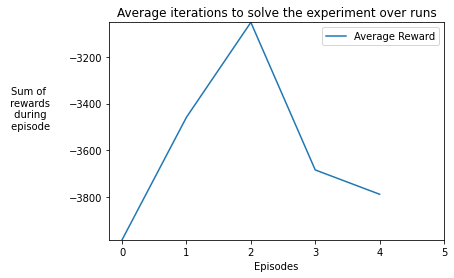

The best reward obtained solving the experiment was: -3051.398316031341

The WorSt reward obtained solving the experiment was: -3983.9627931544774



In [9]:
rewards_average = np.mean(all_rewards, axis=0)
plt.plot(rewards_average, label = 'Average Reward')
plt.xlabel("Episodes")
plt.ylabel("Sum of\n rewards\n during\n episode" ,rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(rewards_average.min(), rewards_average.max())
plt.title("Average iterations to solve the experiment over runs")
plt.legend()
plt.show()
print("The best reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).max()))
print("The WorSt reward obtained solving the experiment was: {0}\n".format(np.array(all_rewards).min()))

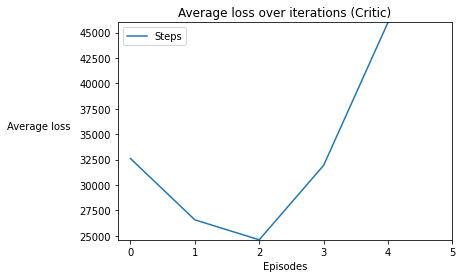

The best loss obtained solving the experiment was: 24606.060758358683

The Worst loss obtained solving the experiment was: 45998.19653555287



In [10]:
loss_average = np.mean(np.array(all_loss_c), axis=0)
plt.plot(loss_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Average loss",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(loss_average.min(), loss_average.max())
plt.title("Average loss over iterations (Critic)")
plt.legend()
plt.show()
print("The best loss obtained solving the experiment was: {0}\n".format(np.array(loss_average).min()))
print("The Worst loss obtained solving the experiment was: {0}\n".format(np.array(loss_average).max()))


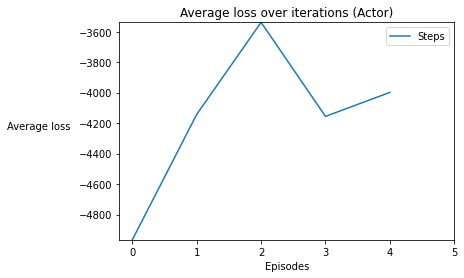

The best loss obtained solving the experiment was: -3538.77587890625

The Worst loss obtained solving the experiment was: -4965.41748046875



In [11]:
loss_average = np.mean(np.array(all_loss_a), axis=0)
plt.plot(loss_average, label = 'Steps')
plt.xlabel("Episodes")
plt.ylabel("Average loss",rotation=0, labelpad=40)
plt.xlim(-0.2, num_episodes)
plt.ylim(loss_average.min(), loss_average.max())
plt.title("Average loss over iterations (Actor)")
plt.legend()
plt.show()
print("The best loss obtained solving the experiment was: {0}\n".format(np.array(loss_average).max()))
print("The Worst loss obtained solving the experiment was: {0}\n".format(np.array(loss_average).min()))


## Using the last trained Agent 

This lines shows in a video the performance of the last trained agent and save a video with the results.

In [12]:
# Test Sarsa Agent 
num_runs = 1
num_episodes = 1000

# Environment
env_to_wrap = gym.make('Pendulum-v0')
# Maximum number of possible iterations (default was 200)
env_to_wrap._max_episode_steps = 1500
env = Monitor(env_to_wrap, "./videos/pendulum", video_callable=lambda episode_id: True, force=True)


# Number of runs are the times the experiment will start again (a.k.a episode)
for n_runs in tqdm(range(num_runs)):
    
    # Resets environment
    observation = env.reset()
    # Generate last state and action in the agent
    last_action = agent.agent_start(observation)
        
    # Times the environment will start again without resetting the agent
    for t in tqdm(range(num_episodes)):

        # View environment
        env.render()

        # Take a step with the environment
        observation, reward, done, info = env.step(last_action)

        # If the goal has been reached stop
        if done:
            # Last step with the agent
            agent.agent_end(reward)
            break

        else:
            # Take a step with the agent
            last_action = agent.agent_step(reward, observation)


env.close()
env_to_wrap.close()

print("Episode finished after {} timesteps".format(t+1))

100%|██████████| 1/1 [00:11<00:00, 11.92s/it]

Episode finished after 1000 timesteps
